In [2]:
import torch 
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

# Generating the Dataset to train for Fibonaccis

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
class FibSeries(Dataset):
    def __init__(self, seq_length=3, tot_samples = 1000):
        self.seq_length = seq_length
        self.tot_samples = tot_samples

        self.seq = []
        self.generate_seq()
        
    def generate_seq(self):
        self.seq = [0, 1]
        for i in range(2, self.tot_samples + self.seq_length):
            self.seq.append(self.seq[i-1] + self.seq[i-2])
    
    def __len__(self):
        return self.tot_samples
    
    def __getitem__(self, idx):
        X = self.seq[idx: idx+self.seq_length]
        Y = self.seq[idx+self.seq_length]
        # return torch.tensor(X, dtype=torch.float64), torch.tensor(Y, dtype=torch.float64) # use float64 for larger datasets > 1000 samples
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1).to(device)
        Y = torch.tensor(Y, dtype=torch.float32).to(device)

        return X, Y


torch.manual_seed(42)
fib_dataset1 = FibSeries(seq_length=3, tot_samples=10)

batch_size = 1
data_loader = DataLoader(fib_dataset1, batch_size, shuffle=True)


In [4]:
for X_batch, Y_batch in data_loader:
    print(X_batch)
    print(Y_batch)
    break  # Just to print one batch for now


tensor([[[21.],
         [34.],
         [55.]]])
tensor([89.])


# RNN Model

In [5]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        
        self.rnn = nn.RNN(input_size=1,
                          hidden_size=8,
                          num_layers=1,
                          batch_first=True)
        
        self.fc1 = nn.Linear(in_features=8,
                             out_features=1,
                             bias=True)

        self.relu = nn.ReLU()
    def forward(self, x):
        
        output, status = self.rnn(x)
        output = output[:, -1, :]  # we need only the last one as our output
        
        output = self.relu(output)
        output = self.fc1(output)

        return output

model = RNNModel().to(device)
print(model)


RNNModel(
  (rnn): RNN(1, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [6]:
X_dummy = torch.randn(4, 3, 1)
model(X_dummy)


tensor([[-0.2563],
        [-0.2470],
        [-0.3208],
        [-0.2619]], grad_fn=<AddmmBackward0>)

# Training

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 5000

In [ ]:
loss_list = []

for ep in range(epochs):

    rloss = 0
    model.train()

    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        ypred = model(input)

        loss = criterion(ypred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rloss += loss.item()
    
    rloss /= len(data_loader)
    loss_list.append(rloss)
    if ep%10 == 0:
        print(f"Ep {ep}/{epochs}: Loss = {rloss}")

Ep 0/5000: Loss = 16.653124118881532
Ep 10/5000: Loss = 16.438149183115456
Ep 20/5000: Loss = 16.32680853085476
Ep 30/5000: Loss = 17.247689001262188
Ep 40/5000: Loss = 16.14961748654605
Ep 50/5000: Loss = 16.016633872018428
Ep 60/5000: Loss = 15.909415320291009
Ep 70/5000: Loss = 15.81158539521275
Ep 80/5000: Loss = 15.709839226526674
Ep 90/5000: Loss = 15.605459687388793
Ep 100/5000: Loss = 15.506481241248547
Ep 110/5000: Loss = 15.409042978391517
Ep 120/5000: Loss = 15.319372742419365
Ep 130/5000: Loss = 15.308384668739745
Ep 140/5000: Loss = 16.023276873701253
Ep 150/5000: Loss = 15.034331390075385
Ep 160/5000: Loss = 14.955816900380887
Ep 170/5000: Loss = 14.973530126072001
Ep 180/5000: Loss = 14.752792472508736
Ep 190/5000: Loss = 14.669088690914213
Ep 200/5000: Loss = 14.566596359084361
Ep 210/5000: Loss = 14.47768187346519
Ep 220/5000: Loss = 14.388806059585477
Ep 230/5000: Loss = 14.301596396171954
Ep 240/5000: Loss = 14.220941881697218
Ep 250/5000: Loss = 14.129283958172891
E

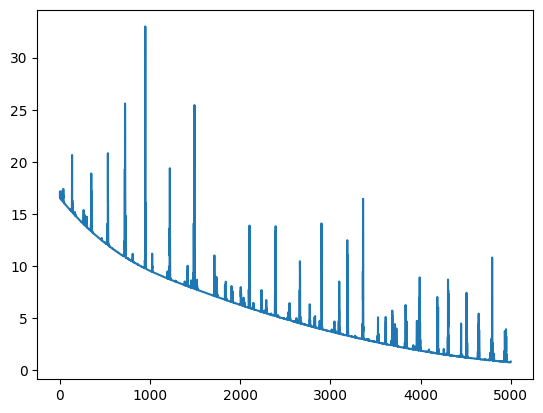

In [17]:
from matplotlib import pyplot as plt
plt.plot(loss_list)

In [18]:
print(f"Last loss = {loss_list[-1]}, from {loss_list[0]} initially")

Last loss = 0.8324268506141379, from 16.653124118881532 initially


# Testing

In [19]:
X_test = [2, 3, 5]
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)
with torch.no_grad():
    ypred = model(X_test).item()

ypred

8.147674560546875

In [24]:
X_test = [8, 13, 21]
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)
with torch.no_grad():
    ypred = model(X_test).item()

ypred

35.17988586425781